<a href="https://colab.research.google.com/github/TheDucker1/DanbooRegion/blob/master/code/DanbooRegion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install h5py

In [2]:
!wget https://github.com/lllyasviel/DanbooRegion/raw/master/code/DanbooRegion2020UNet.net

--2023-11-16 08:12:50--  https://github.com/lllyasviel/DanbooRegion/raw/master/code/DanbooRegion2020UNet.net
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lllyasviel/DanbooRegion/master/code/DanbooRegion2020UNet.net [following]
--2023-11-16 08:12:50--  https://raw.githubusercontent.com/lllyasviel/DanbooRegion/master/code/DanbooRegion2020UNet.net
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31618468 (30M) [application/octet-stream]
Saving to: ‘DanbooRegion2020UNet.net’

DanbooRegion2020UNe 100%[===================>]  30.15M   166MB/s    in 0.2s    

2023-11-16 08:12:51 (166 MB/s) - ‘DanbooRe

In [3]:
import numpy as np

In [4]:
import torch
import torch.nn as nn

class _r_block(nn.Module):
    def __init__(self, in_filters, nb_filters):
        super(_r_block, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_filters, nb_filters, stride=(1, 1), kernel_size=(3, 3), padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(nb_filters, nb_filters, stride=(1, 1), kernel_size=(3, 3), padding='same'),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.model(x)

class _dog(nn.Module):
    def __init__(self):
        super(_dog, self).__init__()
    def forward(self, x):
        down = nn.functional.avg_pool2d(x, 2)
        up = nn.functional.interpolate(down, scale_factor=2)
        return down, x-up

class _cat(nn.Module):
    def __init__(self):
        super(_cat, self).__init__()
    def forward(self, x, y):
        return torch.cat([nn.functional.interpolate(x, scale_factor=2), y], axis=1)

class diff_net_torch(nn.Module):
    def __init__(self):
        super(diff_net_torch, self).__init__()

        self.r_block_1 = _r_block(3, 16)

        self.dog_1 = _dog()
        self.r_block_2 = _r_block(16, 32)

        self.dog_2 = _dog()
        self.r_block_3 = _r_block(32, 64)

        self.dog_3 = _dog()
        self.r_block_4 = _r_block(64, 128)

        self.dog_4 = _dog()
        self.r_block_5 = _r_block(128, 256)

        self.dog_5 = _dog()
        self.r_block_6 = _r_block(256, 512)

        self.cat_1 = _cat()
        self.r_block_7 = _r_block(512+256, 256)

        self.cat_2 = _cat()
        self.r_block_8 = _r_block(256+128, 128)

        self.cat_3 = _cat()
        self.r_block_9 = _r_block(128+64, 64)

        self.cat_4 = _cat()
        self.r_block_10 = _r_block(64+32, 32)

        self.cat_5 = _cat()
        self.r_block_11 = _r_block(32+16, 16)

        self.conv = nn.Conv2d(16, 1, stride=(1, 1), kernel_size=(3, 3), padding='same')

    def forward(self, x):
        c512 = self.r_block_1(x)
        c256, l512 = self.dog_1(c512)
        c256 = self.r_block_2(c256)
        c128, l256 = self.dog_2(c256)
        c128 = self.r_block_3(c128)
        c64, l128 = self.dog_3(c128)
        c64 = self.r_block_4(c64)
        c32, l64 = self.dog_4(c64)
        c32 = self.r_block_5(c32)
        c16, l32 = self.dog_5(c32)
        c16 = self.r_block_6(c16)
        d32 = self.cat_1(c16, l32)
        d32 = self.r_block_7(d32)
        d64 = self.cat_2(d32, l64)
        d64 = self.r_block_8(d64)
        d128 = self.cat_3(d64, l128)
        d128 = self.r_block_9(d128)
        d256 = self.cat_4(d128, l256)
        d256 = self.r_block_10(d256)
        d512 = self.cat_5(d256, l512)
        d512 = self.r_block_11(d512)
        y = self.conv(d512)
        return y


In [5]:
vector_torch = diff_net_torch()

In [6]:
MAPPING = {
    'c512_c1': ('r_block_1', 'model', '0',),
    'c512_c2': ('r_block_1', 'model', '2',),
    'c256_c1': ('r_block_2', 'model', '0',),
    'c256_c2': ('r_block_2', 'model', '2',),
    'c128_c1': ('r_block_3', 'model', '0',),
    'c128_c2': ('r_block_3', 'model', '2',),
    'c64_c1': ('r_block_4', 'model', '0',),
    'c64_c2': ('r_block_4', 'model', '2',),
    'c32_c1': ('r_block_5', 'model', '0',),
    'c32_c2': ('r_block_5', 'model', '2',),
    'c16_c1': ('r_block_6', 'model', '0',),
    'c16_c2': ('r_block_6', 'model', '2',),
    'd32_c1': ('r_block_7', 'model', '0',),
    'd32_c2': ('r_block_7', 'model', '2',),
    'd64_c1': ('r_block_8', 'model', '0',),
    'd64_c2': ('r_block_8', 'model', '2',),
    'd128_c1': ('r_block_9', 'model', '0',),
    'd128_c2': ('r_block_9', 'model', '2',),
    'd256_c1': ('r_block_10', 'model', '0',),
    'd256_c2': ('r_block_10', 'model', '2',),
    'd512_c1': ('r_block_11', 'model', '0',),
    'd512_c2': ('r_block_11', 'model', '2',),
    'op': ('conv',)
}

In [8]:
import h5py
net_name = 'DanbooRegion2020UNet.net'
vt_state_dict = vector_torch.state_dict()
with h5py.File(net_name, "r") as F:
    F = F['model_weights']
    for keras_layer in MAPPING:
        Weight = F[keras_layer]['generator'][keras_layer]['kernel:0'][()]
        Bias = F[keras_layer]['generator'][keras_layer]['bias:0'][()]
        vt_state_dict['.'.join(MAPPING[keras_layer]) + '.weight'] = torch.from_numpy(Weight.transpose(3,2,0,1))
        vt_state_dict['.'.join(MAPPING[keras_layer]) + '.bias'] = torch.from_numpy(Bias)
vector_torch.load_state_dict(vt_state_dict)

<All keys matched successfully>

In [9]:
def go_vector(img):
    tensor = torch.from_numpy(img.astype(np.float32).transpose(2,0,1)[np.newaxis,:] / 255.)
    with torch.no_grad():
        pred = vector_torch(tensor)
    return 1. - pred.cpu().detach().numpy()[0].transpose(1,2,0)
def go_flipped_vector(x):
    a = go_vector(x)
    b = np.fliplr(go_vector(np.fliplr(x)))
    c = np.flipud(go_vector(np.flipud(x)))
    d = np.flipud(np.fliplr(go_vector(np.flipud(np.fliplr(x)))))
    return (a + b + c + d) / 4.0
def go_transposed_vector(x):
    a = go_flipped_vector(x)
    b = np.transpose(go_flipped_vector(np.transpose(x, [1, 0, 2])), [1, 0, 2])
    return (a + b) / 2.0

--2023-11-16 08:19:20--  https://raw.githubusercontent.com/lllyasviel/DanbooRegion/master/page_imgs/pre_img.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 456091 (445K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>] 445.40K  --.-KB/s    in 0.04s   

2023-11-16 08:19:21 (9.74 MB/s) - ‘test.jpg’ saved [456091/456091]



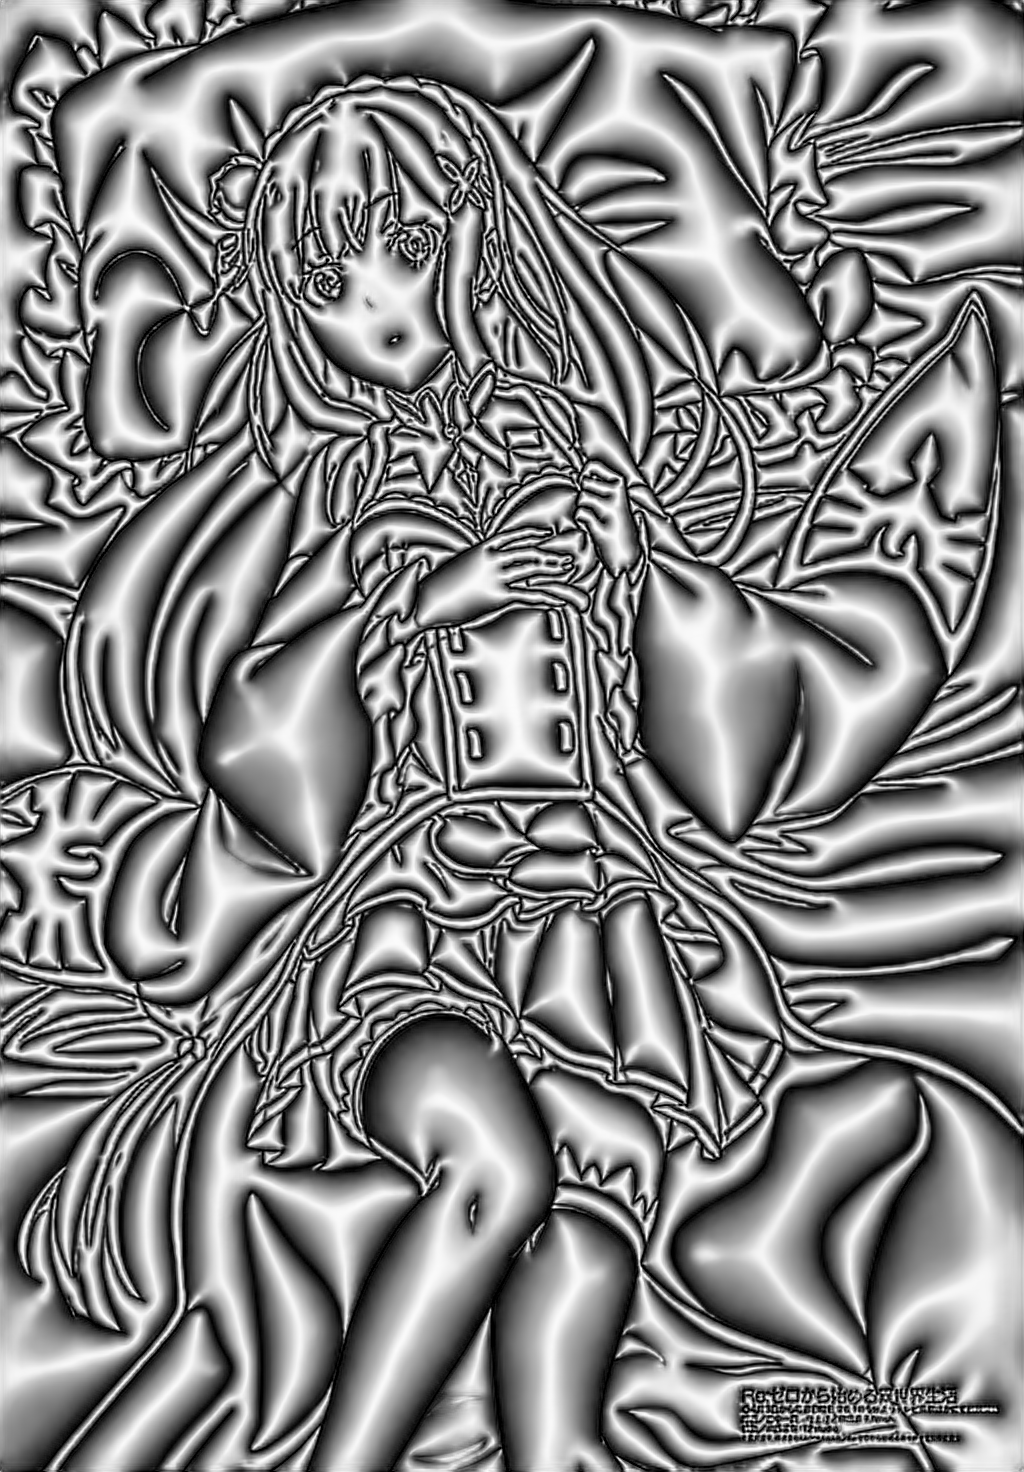

In [13]:
!wget -O test.jpg https://raw.githubusercontent.com/lllyasviel/DanbooRegion/master/page_imgs/pre_img.jpg
import cv2
from google.colab.patches import cv2_imshow
im = cv2.imread('test.jpg', cv2.IMREAD_COLOR)
old_shape = im.shape[:2]
im = cv2.resize(im, (im.shape[1] // 64 * 64, im.shape[0] // 64 * 64))

#[insert the srcnn pass here]
out = go_vector(im)

out = cv2.resize(out, (old_shape[1], old_shape[0]))
cv2_imshow(go_vector(im) * 255)

In [14]:
torch.save(vector_torch.state_dict(), './DanbooRegion2020UNet_torch.pt')